In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from PIL import Image
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import timm
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
import os

c:\Users\Jomar\VSCode\ML\BasicML\ML\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [4]:
root_dir = 'KDEF'
train_dataset = ImageFolder(os.path.join(root_dir, 'train'), transform=transform)
test_dataset = ImageFolder(os.path.join(root_dir, 'test'), transform=transform)
print("Total training images:", len(train_dataset))


Total training images: 4409


No point in loading it into RAM, too large

In [5]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_subset, val_subset =  random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size= 32, num_workers= 4, persistent_workers= True, pin_memory= True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, pin_memory= True, num_workers= 2, persistent_workers= True)
test_loader = DataLoader(test_dataset, batch_size= 32, shuffle= False)

In [6]:
# load the pre-trained efficientnet model
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=2)

# Move model to GPU if available
model = model.to(device)

In [11]:
class_names = train_dataset.classes

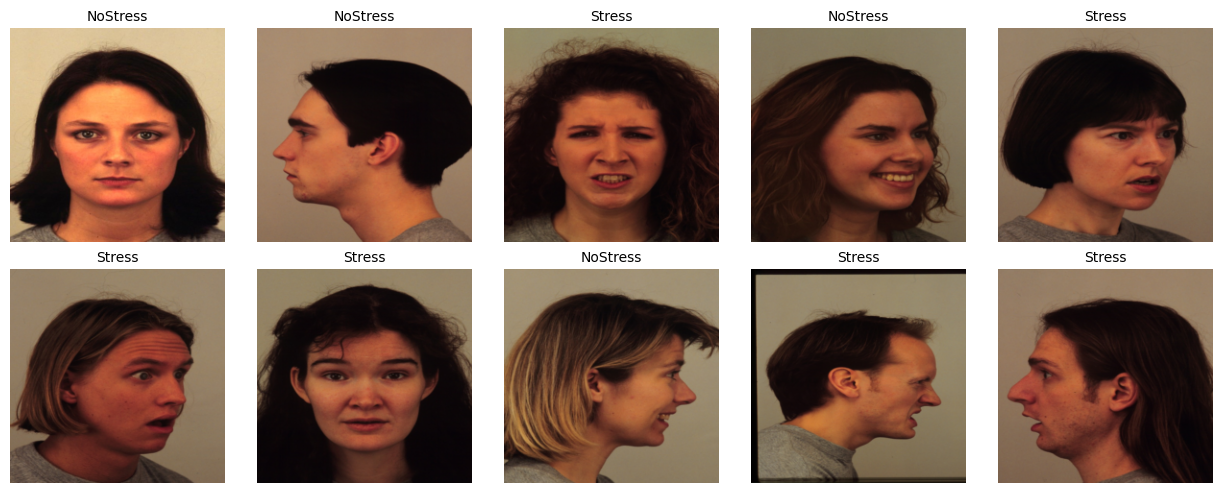

In [ ]:
#view samples of the data
import matplotlib.pyplot as plt
import numpy as np

def imshow_batch(inputs, classes, class_names, num_images=10):
    #displays a batch of images
    inputs = inputs[:num_images]
    classes = classes[:num_images]
    
    # Setup subplot grid
    rows = 2
    cols = (num_images + 1) // 2
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))
    axes = axes.flatten()

    for idx, (img_tensor, label) in enumerate(zip(inputs, classes)):
        img = img_tensor.numpy().transpose((1, 2, 0))  # CHW → HWC
        img = (img * 0.5) + 0.5  # Unnormalize
        img = np.clip(img, 0, 1)

        axes[idx].imshow(img)
        axes[idx].set_title(class_names[label], fontsize=10)
        axes[idx].axis('off')

    # Hide unused subplots
    for ax in axes[num_images:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

inputs, classes = next(iter(train_loader))
imshow_batch(inputs, classes, class_names, num_images=10)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

In [8]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch + 1, num_epochs))

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Enable dropout, batchnorm, etc.
            else:
                model.eval()   # Disable dropout, batchnorm

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Only track gradients in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Accumulate loss and correct predictions
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Compute epoch-level metrics (outside batch loop)
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Optional: Clear cached memory after each epoch
        torch.cuda.empty_cache()



In [9]:
train_model(model, {'train': train_loader, 'val': val_loader}, criterion, optimizer, num_epochs=10)


Epoch 1/10
Train Loss: 0.9484 Acc: 0.7658
Val Loss: 2.3427 Acc: 0.8322
Epoch 2/10
Train Loss: 0.1039 Acc: 0.9640
Val Loss: 2.0116 Acc: 0.8764
Epoch 3/10
Train Loss: 0.0167 Acc: 0.9935
Val Loss: 0.4973 Acc: 0.8844
Epoch 4/10
Train Loss: 0.0026 Acc: 0.9994
Val Loss: 2.5039 Acc: 0.8878
Epoch 5/10
Train Loss: 0.0013 Acc: 1.0000
Val Loss: 0.9519 Acc: 0.8878
Epoch 6/10
Train Loss: 0.0010 Acc: 1.0000
Val Loss: 1.1416 Acc: 0.8878
Epoch 7/10
Train Loss: 0.0008 Acc: 1.0000
Val Loss: 1.0146 Acc: 0.8900
Epoch 8/10
Train Loss: 0.0007 Acc: 1.0000
Val Loss: 1.1229 Acc: 0.8878
Epoch 9/10
Train Loss: 0.0006 Acc: 1.0000
Val Loss: 1.2202 Acc: 0.8900
Epoch 10/10
Train Loss: 0.0005 Acc: 1.0000
Val Loss: 1.3361 Acc: 0.8923


In [12]:
def eval_model(model, dataloader):
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _,preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print("Classification Summary:")
    print(classification_report(y_true, y_pred, target_names = class_names))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

eval_model(model, test_loader)

Classification Summary:
              precision    recall  f1-score   support

    NoStress       0.89      0.84      0.86       842
      Stress       0.88      0.92      0.90      1049

    accuracy                           0.88      1891
   macro avg       0.88      0.88      0.88      1891
weighted avg       0.88      0.88      0.88      1891

Confusion Matrix:
[[708 134]
 [ 87 962]]


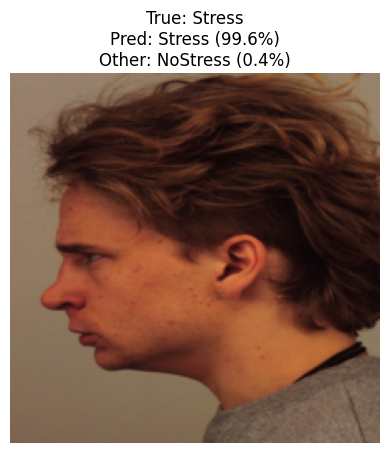

In [29]:
import random
import matplotlib.pyplot as plt

def predict_image(model, dataloader, class_names, device):
    model.eval()

    dataset = dataloader.dataset
    random_idx = random.randint(0, len(dataset) - 1)
    image, label = dataset[random_idx]

    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        probs = F.softmax(outputs, dim = 1).cpu().numpy()
        pred_class = torch.argmax(outputs, dim = 1).item()

    #unnorm image
    img = image.squeeze(0).permute(1,2,0).cpu().numpy()
    img = (img * 0.5) + 0.5

    plt.imshow(img)
    plt.axis('off')
    plt.title(
        "True: {}\nPred: {} ({:.1f}%)\nOther: {} ({:.1f}%)".format(
            class_names[label],
            class_names[pred_class],
            probs[0][pred_class] * 100,
            class_names[1 - pred_class],
            probs[0][1 - pred_class] * 100
        )
    )
    plt.show()

predict_image(model, test_loader, class_names, device)